## Solving the environment

In [1]:
# HIDDEN
import gym
import numpy as np
from ray.rllib.algorithms.ppo import PPO, PPOConfig

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

#### Solving with RLlib

- Let's see if we can do better than 25.5 with RLlib.
- We'll set up a config file for our RLlib trainer as usual.

In [2]:
env_config = {
    "num_candidates" : 2,
    "alpha"          : 0.5,
    "seed"           : 42
}

ppo_config = (
    PPOConfig()\
    .framework("torch")\
    .rollouts(create_env_on_local_worker=True)\
    .debugging(seed=0, log_level="ERROR")\
    .training(model={"fcnet_hiddens" : [64, 64]}, lr=0.001)\
    .environment(env_config=env_config)
)

- We'll set `fcnet_hiddens` as in the previous module.
- The `lr` parameter sets the learning rate. 
- `env_config` passes info about the environment.

Notes:

We found 0.001 to work a bit better than the default of 0.0001.
As in the previous module, we'll set the neural network architecture to be smaller than the default, so that the code runs a bit faster.
See how we pass the environment config into the broader RLlib algorithm config. RLlib will pass it on to the environment for us.

#### Solving with RLlib

Next, we set up our trainer:

In [3]:
from envs import BasicRecommender

In [4]:
ppo = ppo_config.build(env=BasicRecommender)

(RolloutWorker pid=10988) /Users/mike/git/anyscale/ray/python/ray/rllib/utils/debug/deterministic.py:42: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
(RolloutWorker pid=10988)   if LooseVersion(torch.__version__) >= LooseVersion("1.8.0"):


And then we train for 25 iterations:

In [5]:
rewards = []
for i in range(25):
    result = ppo.train()
    rewards.append(result["episode_reward_mean"])

(RolloutWorker pid=10987) /Users/mike/git/anyscale/ray/python/ray/rllib/utils/debug/deterministic.py:42: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
(RolloutWorker pid=10987)   if LooseVersion(torch.__version__) >= LooseVersion("1.8.0"):


Finally, we print out the average episode reward over 1000 episodes:

In [6]:
# HIDDEN
np.random.seed(1)

In [7]:
ppo.evaluate(duration_fn=1000)["evaluation"]["episode_reward_mean"]

25.306779804899506

Hmm....

Notes:

The results look underwhelming here. They are about the same as the random agent.

#### Is the agent learning?

We can try plotting the reward across training iterations:

In [8]:
# HIDDEN
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 16

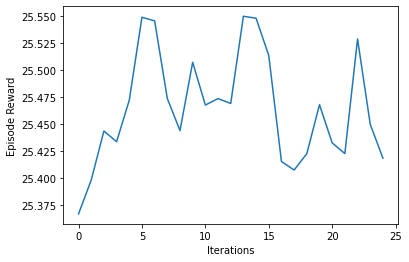

In [9]:
plt.plot(rewards);
plt.xlabel("Iterations");
plt.ylabel("Episode Reward");

- It looks like learning is not happening very effectively here.
- And we don't do better than random (25.5).

#### What is this agent doing?

We can check out what the agent is thinking:

In [10]:
# HIDDEN
from utils import query_policy

In [11]:
env = BasicRecommender(env_config)

In [12]:
query_policy(ppo, env, np.array([0,1]), actions=[0,1])

array([0.05680975, 0.94319034], dtype=float32)

In [13]:
query_policy(ppo, env, np.array([1,0]), actions=[0,1])

array([0.80560195, 0.19439809], dtype=float32)

The agent chooses candy most of the time.

Notes: 

First, we are passing in the observation [0,1], meaning the first item is veggies and the second is candy. We see the corresponding action probabilities 29% and 71%. Then we try switching the order of the items, hence [0,1]. We expect something roughly symmetrical, though the symmetry is not exact, due to arbitrary/random effects in the simulation and the RL training.

#### Discount factor

- The agent is a bit more "greedy" than random - it takes candy more often. Why?
- During RL training, we don't actually maximize total reward.
- We maximize total _discounted_ reward.
- That is, for episodes of length 100,

![](img/discounted_reward.png)

- The default value for PPO in RLlib is 0.99:

In [14]:
ppo.config["gamma"]

0.99

Notes:

Thus, the agent would rather gain 0.1 extra reward now even if it loses 0.1 reward later on. In fact, it would rather gain 0.1 extra reward now even if it loses 0.2 extra reward 100 time steps later. In one of the upcoming coding exercises we'll explore this phenomenon a bit more.

Choosing some gamma less than 1 is needed for RL training to work properly. The exact choice of gamma is fairly arbitrary but the default of 0.99 is a popular choice.

#### What is this agent doing?

We can also try intermediate sweetness values:

In [15]:
query_policy(ppo, env, np.array([0.5, 0.5]), actions=[0,1])

array([0.10257396, 0.897426  ], dtype=float32)

In [16]:
query_policy(ppo, env, np.array([0.25, 0.25]), actions=[0,1])

array([0.31589672, 0.68410325], dtype=float32)

- The agent seems to prefer action "1" to action "0".
- This is completely arbitrary.

Notes:

There is randomness during the training that breaks the symmetry.
Randomness both in the env and in the RL algorihtm.

#### Can we improve the agent?

- Can we improve the agent?
- In the last module we talked about the observation space.
- Can we provide the agent with more information?
- (Feel free to think about this for a minute!)

🤔...

#### Observation space

- Currently the agent's actions only depend on the _currently_ available items.
- What if the agent knew more about the past or the future?
- We'll try: giving the agent a brief "memory" of what items it chose recently.

Notes:

For example. If the agent new it was the last time step of the episode, it should always just pick the sweetest item.

#### Recording history - constructor

We'll need to modify the code in a couple places.

In [17]:
class BasicRecommenderWithHistory(gym.Env):
    def __init__(self, env_config=None):
        # Set parameters    
        self.num_candidates = env_config.get("num_candidates", 10)
        self.alpha = env_config.get("alpha", 0.9)
        self.history_len = env_config.get("history_len", 2) # new

        # Set observation and action spaces
        self.observation_space = gym.spaces.Box(low=0, high=1, 
                    shape=(self.num_candidates + self.history_len,)) # changed
        self.action_space = gym.spaces.Discrete(self.num_candidates)

Notes:
    
There are two changes here. First, we added a new parameter called history_len, which is the number of steps backward that we record history. 
Second, we changed the observation space shape to be num_candidates + history_len instead of just num_candidates. This way the agent sees the same feature information as before, plus additional information of the previously chosen item features.

#### Recording history - other changes

We'll also need to modify a few other things:

- `reset()` will reset the history 
- The observations returned will concatenate the item features with the history 
- `step()` will need to shift the history and place the most recent chosen item into history

The code is not shown here but is available at our GitHub repo.

#### Recording history

Let's test it out.

In [18]:
# HIDDEN
from envs import BasicRecommenderWithHistory

In [19]:
env = BasicRecommenderWithHistory(env_config)

In [20]:
env.reset()

array([0.37454012, 0.95071431, 0.        , 0.        ])

In [21]:
env.step(0)

(array([0.73199394, 0.59865848, 0.37454012, 0.        ]),
 0.3745401188473625,
 False,
 {'sugar_level': 0.18727005942368125})

In [22]:
env.step(1)

(array([0.15601864, 0.15599452, 0.59865848, 0.37454012]),
 0.4865476742869666,
 False,
 {'sugar_level': 0.3929642718103589})

In [23]:
env.step(1)

(array([0.05808361, 0.86617615, 0.15599452, 0.59865848]),
 0.09469424724588053,
 False,
 {'sugar_level': 0.27447939607328076})

Notes:

- Here we see the item features _and_ the (empty) history.
- Since we chose item 0, it is placed into the history.
- We are given 2 new item candidates as usual.
- As we continue to step, the history gets shifted.

#### Does this help?

Let's try training an agent with this new observation space 🤖

In [24]:
ppo_history = ppo_config.build(env=BasicRecommenderWithHistory)

(RolloutWorker pid=11134) /Users/mike/git/anyscale/ray/python/ray/rllib/utils/debug/deterministic.py:42: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
(RolloutWorker pid=11134)   if LooseVersion(torch.__version__) >= LooseVersion("1.8.0"):


And then we train for 25 iterations:

In [25]:
# HIDDEN
# np.random.seed(1)

In [26]:
rewards_history = []
for i in range(25):
    result = ppo_history.train()
    rewards_history.append(result["episode_reward_mean"])

(RolloutWorker pid=11135) /Users/mike/git/anyscale/ray/python/ray/rllib/utils/debug/deterministic.py:42: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
(RolloutWorker pid=11135)   if LooseVersion(torch.__version__) >= LooseVersion("1.8.0"):


In [27]:
ppo_history.evaluate(duration_fn=1000)["evaluation"]["episode_reward_mean"]

25.919834245276224

This time, we exceeded $26M 💰🚀

#### Training curve

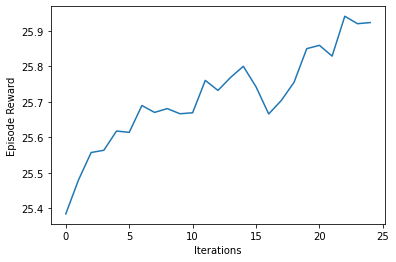

In [29]:
plt.plot(rewards_history);
plt.xlabel("Iterations");
plt.ylabel("Episode Reward");

This also looks a lot healthier.

In [52]:
# TODO
# show that a deterministic agent will do terribly (e.g. DQN)?

#### Policy

In [34]:
query_policy(ppo_history, env, np.array([1,0,0,0]), actions=[0,1])

array([0.85885483, 0.14114514], dtype=float32)

In [1]:
query_policy(ppo_history, env, np.array([1,0,1,1]), actions=[0,1])

Notes:

- Note how the agent now leans toward veggies if it had a lot of candy recently, and vice versa.
- That is, when it sees candy and veggies, its decision is influenced by the past.

#### Let's apply what we learned!

## Recommender rewards
<!-- multiple choice -->

In the slides above we improved our agent by augmenting the observation space. In module 3 we talked about encoding the observation space, and also about _reward shaping_. We discussed reward shaping in the context of trying to train the agent more successfully. However, we may also simply want to change our definition of success. 

Let's say that we our organization does not just want to maximize profits, but also create an ethical recommender AI that doesn't feed users too much candy. Which of the following new reward functions would best achieve this?

As a reminder, here is the current reward function:

```python
def reward(self, item_sweetness):
    return item_sweetness * (1 - self.sugar_level)
```

- [ ] `item_sweetness/2 * (1 - self.sugar_level)` | This is a rescaling of the old reward function, but does not change the relative rewards of different actions.
- [x] `item_sweetness * (1/2 - self.sugar_level)` | This is effectively a penalty of item_sweetness/2, thus penalizing sweeter items, including potentially negative rewards for overly sweet items.
- [ ] `item_sweetness * (1 - self.sugar_level/2)` | This makes the sugar effect less potent, which may encourage sweeter items.

In [ ]:
# TODO
# check the above multiple choice to make sure the behaviour of an agent is as expected

## Discount factor
<!-- coding exercise -->

The slides introduced the idea of the _discount factor_, namely that the agent is really maximizing something like this:

![](img/discounted_reward.png)

In RLlib, we can set the discount factor by setting `"gamma"` in the algorithm config. The default value is 0.99. In the code below, change the value of `"gamma"` to 0.5, 0.9, 0.99 (default), and 0.9999, and observe how the trained agent responds to the choice of veggies vs. candy. Then, answer the multiple choice question below.

In [8]:
# EXERCISE
import numpy as np
from ray.rllib.algorithms.ppo import PPOConfig
from envs import BasicRecommender
from utils import query_policy

env_config = {
    "num_candidates" : 2,
    "alpha"          : 0.5,
    "seed"           : 42
}

ppo_config = ( # change "gamma" in here
    PPOConfig()\
    .framework("torch")\
    .rollouts(create_env_on_local_worker=True)\
    .debugging(seed=0, log_level="ERROR")\
    .training(model={"fcnet_hiddens" : [64, 64]}, lr=0.001, gamma=0.99)\
    .environment(env_config=env_config)
)

ppo = ppo_config.build(env=BasicRecommender)

rewards = []
for i in range(5):
    result = ppo.train()
    rewards.append(result["episode_reward_mean"])

env = BasicRecommender(env_config)
env.reset()
print(query_policy(ppo, env, np.array([0,1]), actions=[0,1]))

ppo.stop()

[0.34318933 0.65681064]


In [ ]:
# SOLUTION


In [11]:
# HIDDEN
{
0.5  : 0.94,
0.9 : 0.65,
0.99 : 0.365, 
0.9999 : 30,
};

#### How does gamma affect the agent's candy-seeking behavior?

- [x] When gamma is larger, the agent is more interested in candy
- [ ] When gamma is larger, the agent is less interested in candy
- [ ] The agent's candy-seeking does not exhibit a clear dependence on gamma

In [ ]:
# TODO
# ## Another coding exercise
# <!-- coding exercise -->

# Talk about changing alpha, or changing num_candidates, or something.

# Or, having the initial sugar level be random. would that be interesting at all? i guess that's one of those cases where, in that case, it would help to have the reward be part of the observation, as that is useful info. a bit confusing.

# ANOTHER IDEA: what if the candidates were sorted by sweetness. that might help make learning a lot faster? would be interesting then for 3 or more candidates, to see if it every picks the middle one. 

# it's sort of like having a user feature but more transient. 